In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold, TimeSeriesSplit
from sklearn import svm
from pyswarms.single.global_best import GlobalBestPSO

import wta, ic
import metrics as me

import os
import math

In [2]:
data_dir = '../data/planetlab'
# smooth_csv = ('20110303', 'ait05_us_es_root')
smooth_csv = ('20110306', 'planetlab1_cs_purdue_edu_purdue_2')
trend_csv = ('20110412', 'planet1_scs_cs_nyu_edu_uw_oneswarm')
period_csv = ('20110403', 'planetlab2-santiago_lan_redclara_net_ethzcs_tracegatherer')

smooth_df = pd.read_csv(os.path.join(data_dir, *smooth_csv))
trend_df = pd.read_csv(os.path.join(data_dir, *trend_csv))
period_df = pd.read_csv(os.path.join(data_dir, *period_csv))

In [3]:
smooth_ts, trend_ts, period_ts = wta.pre(smooth_df, trend_df, period_df)

In [4]:
smooth_wl_type, smooth_period = wta.workload_aware(smooth_ts)
trend_wl_type, trend_period = wta.workload_aware(trend_ts)
period_wl_type, period = wta.workload_aware(period_ts)
smooth_wl_type, trend_wl_type, (period_wl_type, period)

('SMOOTH', 'TREND', ('PERIOD', 47))

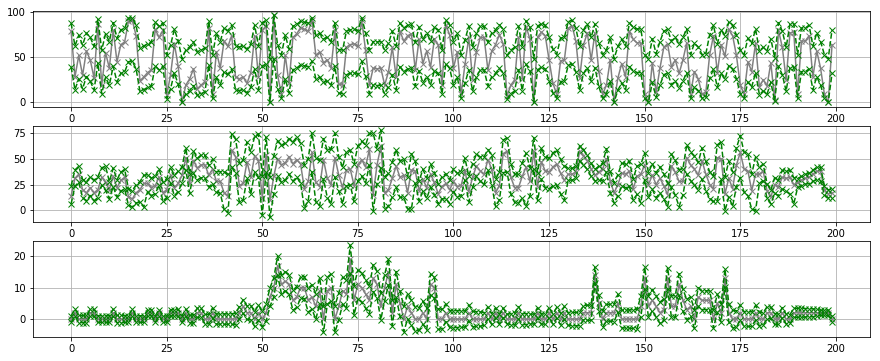

In [5]:
smooth_ts_up, smooth_ts_low = ic.ic(smooth_ts, smooth_wl_type)
trend_ts_up, trend_ts_low = ic.ic(trend_ts, trend_wl_type)
period_ts_up, period_ts_low = ic.ic(period_ts, period_wl_type, period)

st, ed = 50, 250
plt.figure(figsize=(15,6))
plt.subplot(311)
origin1 = smooth_ts[st:ed]
origin1.index = range(len(origin1))
plt.plot(origin1, color='gray', marker='x')
plt.grid()
plt.plot(smooth_ts_up[st:ed], linestyle='--', color='green', marker='x')
plt.plot(smooth_ts_low[st:ed], linestyle='--', color='green', marker='x')

plt.subplot(312)
origin2 = trend_ts[st:ed]
origin2.index = range(len(origin2))
plt.plot(origin2, color='gray', marker='x')
plt.grid()
plt.plot(trend_ts_up[st:ed], linestyle='--', color='green', marker='x')
plt.plot(trend_ts_low[st:ed], linestyle='--', color='green', marker='x')

plt.subplot(313)
origin3 = period_ts[st:ed]
origin3.index = range(len(origin3))
plt.plot(origin3, color='gray', marker='x')
plt.grid()
plt.plot(period_ts_up[st:ed], linestyle='--', color='green', marker='x')
plt.plot(period_ts_low[st:ed], linestyle='--', color='green', marker='x')

In [6]:
# 样本集大小
smooth_ts_up.shape, smooth_ts_low.shape, trend_ts_up.shape, trend_ts_low.shape,period_ts_up.shape, period_ts_low.shape

((287,), (287,), (287,), (287,), (287,), (287,))

In [7]:
sample_size = 287

train_size = 200
x_size = 4
# train_test_split for smooth_ts_up and smooth_ts_low
smu_train, smu_test = smooth_ts_up[:train_size], smooth_ts_up[train_size:]
sml_train, sml_test = smooth_ts_low[:train_size], smooth_ts_low[train_size:]
sm_train = np.array(smooth_ts[:train_size])

# train_test_split for trend_ts_up and trend_ts_low
tru_train, tru_test = trend_ts_up[:train_size], trend_ts_up[train_size:]
trl_train, trl_test = trend_ts_low[:train_size], trend_ts_low[train_size:]
tr_train = np.array(trend_ts[:train_size])

# train_test_split for period_ts_up and period_ts_low
peu_train, peu_test = period_ts_up[:train_size], period_ts_up[train_size:]
pel_train, pel_test = period_ts_low[:train_size], period_ts_low[train_size:]
pe_train = np.array(period_ts[:train_size])

In [8]:
def split_to_xy(ts, d=range(1,4)):
    """将原时序数据转变为x,y两个数列,
    x（向量，每个分量x[i]滞后期为d[i]）作为svm回归的自变量
    """
    x=np.empty((0,len(d)))
    y = np.array([])
    for i in range(len(ts)):
        # 相应滞后的值在原序列中的索引
        idx = []
        for j in d:
            k = i - j
            if k >= 0:
                idx.append(k)
            else:
                idx = []
                break;
        x_d = []
        for j in idx:
            x_d.append(ts[j])
        if len(x_d) != 0:
            x_d = np.array([x_d])
            x = np.row_stack((x, x_d))
            y = np.append(y, ts[i])
    return x, y

def cross_predict(train_u, test_u, train_l, test_l, svr_u, svr_l, d_u=(1,3), d_l=(1,3)):
    """返回对测试集 test_u, test_l的上下界预测
    """
    xu_tr, yu_tr = split_to_xy(train_u, d=range(*d_u))
    xu_te, yu_te = split_to_xy(test_u, d=range(*d_u))
    svr_u.fit(xu_tr, yu_tr)
    pu = svr_u.predict(xu_te)
    
    xl_tr, yl_tr = split_to_xy(train_l, d=range(*d_l))
    xl_te, yl_te = split_to_xy(test_l, d=range(*d_l))
    svr_l.fit(xl_tr, yl_tr)
    pl = svr_l.predict(xl_te)
    return pu, pl, len(d_u)

def cwcf(gamma_u, C_u, gamma_l, C_l, cv_t, cv_u, cv_l,cv=3, mu=0.6, eta=10, isplt=False):
    """计算交叉验证的cwc（区间覆盖宽度标准） picp（区间覆盖率） pinew（区间宽度）
    cv: 折数
    mu: 预测置信区间
    eta: 惩罚因子，表现算法偏好度。eta增加提升picp；eta减小，提升pinew
    isplt: 是否将每折画图
    """
    tscv = TimeSeriesSplit(n_splits=cv)
    cwc_l = []
    picp_l = []
    pinew_l = []
    i_cv = 0
    plot_num = cv*100 + 3*10
    for tridx, teidx in tscv.split(cv_u):
        cv_tr_u, cv_te_u = cv_u[tridx], cv_u[teidx]
        cv_tr_l, cv_te_l = cv_l[tridx], cv_l[teidx]
        cv_tr_t, cv_te_t = cv_t[tridx], cv_t[teidx]
        
        svr_u = svm.SVR(gamma=gamma_u, C=C_u)
        svr_l = svm.SVR(gamma=gamma_l, C=C_l)
        pu, pl, d = cross_predict(cv_tr_u, cv_te_u, cv_tr_l, cv_te_l, svr_u, svr_l)
        
        if isplt:
            plt.figure(figsize=(15,6))
            plt.subplot(plot_num+1)
            plt.title('cv train %d' % (i_cv))
            plt.plot(cv_tr_u, color='blue', marker='o')
            plt.plot(cv_tr_l, color='blue', marker='o')
            plt.plot(cv_tr_t, color='gray', marker='x')
            plt.subplot(plot_num+2)
            plt.title('cv test %d' % (i_cv))
            plt.plot(cv_te_u, color='blue', marker='o')
            plt.plot(cv_te_l, color='blue', marker='o')
            plt.plot(cv_te_t, color='gray', marker='x')
            plt.subplot(plot_num+3)
            plt.title('cv predict %d' % (i_cv))
            plt.plot(pu, color='blue', marker='o')
            plt.plot(pl, color='blue', marker='o')
            plt.plot(cv_te_t[d:], color='gray', marker='x')
        i_cv += 1
        plot_num += 3
        
        picp = picpf(cv_te_t[d:], pu, pl)
        picp_l.append(picp)
        pinew = pinewf(pu, pl)
        pinew_l.append(pinew)
        gamma = 1
        if picp >= mu:
            gamma = 0
        cwc = pinew * (1 + gamma * np.exp(-eta*(picp-mu)))
        cwc_l.append(cwc)
    return np.array(cwc_l).mean(), np.array(picp_l).mean(), np.array(pinew_l).mean()

def pso_fitf(x, cv_t, cv_u, cv_l, cv=3, mu=0.6, eta=10):
    """pso 优化的目标函数"""
    n_particles = x.shape[0]
    los = []
    for i in range(n_particles):
        cwc, picp, pinew = cwcf(*x[i], cv_t, cv_u, cv_l, cv, mu, eta)
        los.append(cwc)
    return los

def pso_bounds(gamma_u=(0.001, 1.0), C_u=(10,30), gamma_l=(0.001, 1.0), C_l=(10,30)):
    """gamma与C范围
    """
    gamma_u_bounds = np.array(gamma_u).reshape(2,1)
    C_u_bounds = np.array(C_u).reshape(2,1)
    gamma_l_bounds = np.array(gamma_l).reshape(2,1)
    C_l_bounds = np.array(C_l).reshape(2,1)
    
    bounds = np.column_stack((gamma_u_bounds, C_u_bounds, gamma_l_bounds, C_l_bounds))
    return bounds[0], bounds[1]

def picpf(ts, pu, pl):
    c_num = len(ts)
    if c_num == 0:
        raise RuntimeError('time series is empty')
    c_sum = 0
    for i in range(c_num):
        val_t = ts[i]
        if pl[i] <= val_t <= pu[i]:
            c_sum += 1
    return c_sum / c_num

def pinewf(pu, pl):
    if len(pu) == 0 or len(pl) == 0:
        raise RuntimeError('up or low bound is empty')
    if len(pu) != len(pl):
        raise RuntimeError('size of up an low bound is not equal')
    max_u = pu.max()
    min_l = pl.min()
    r = max_u - min_l
    b_num = len(pu)
    b_sum = 0
    for i in range(b_num):
        b_sum += (pu[i] - pl[i]) / r
    return b_sum / b_num

# 检验smooth

In [9]:
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
sm_optimizer = GlobalBestPSO(n_particles=10, dimensions=4, options=options, bounds=pso_bounds())
kwargs = {'cv_t': sm_train, 'cv_u': smu_train, 'cv_l': sml_train}
sm_cost, sm_pos = sm_optimizer.optimize(pso_fitf, iters=1000, **kwargs)

2019-03-03 21:24:20,410 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.885
2019-03-03 21:28:40,991 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.8853172741197902, best pos: [ 0.04243267 26.25840938  0.22171748 21.35419768]


In [10]:
# array([ 0.04243267, 26.25840938,  0.22171748, 21.35419768])
sm_pos

array([ 0.04243267, 26.25840938,  0.22171748, 21.35419768])

(0.8853172741197902, 0.5902777777777777, 0.6089023165189916)

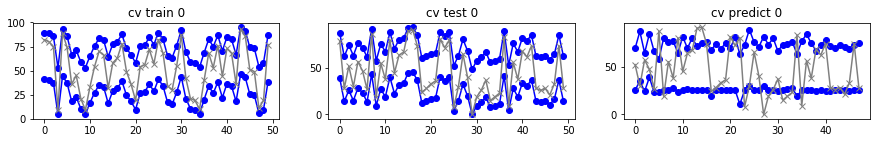

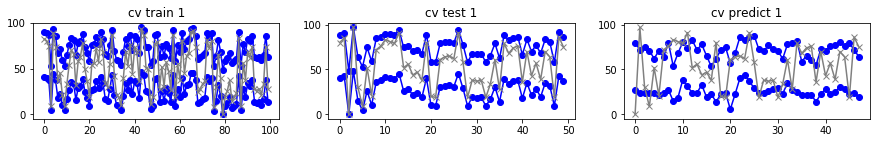

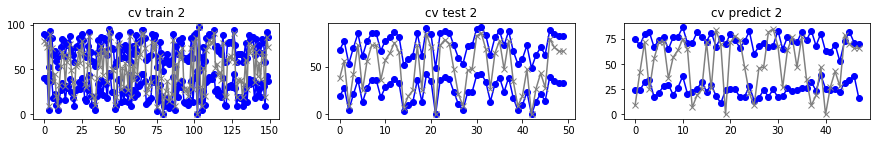

In [11]:
cwcf(*sm_pos, sm_train, smu_train, sml_train, isplt=True)

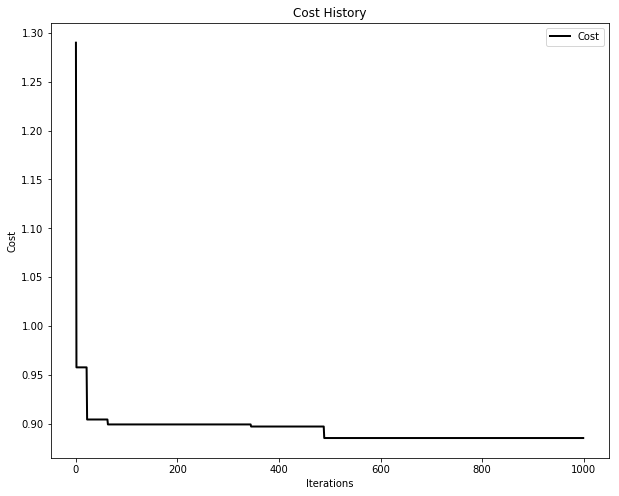

In [12]:
from pyswarms.utils.plotters import plot_cost_history, plot_contour, plot_surface
plot_cost_history(sm_optimizer.cost_history)

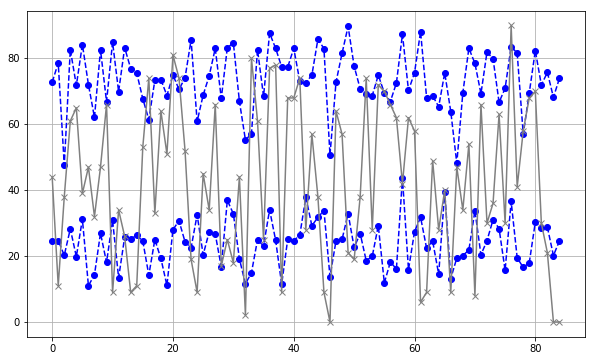

In [63]:
# 滞后期数列 d>1 因为不能用当前点预测当前点
# svm gamma取值范围[0.0001, 1] C取值范围[1,30]，这个范围之后用在
diff = 3
xu_tr, yu_tr = split_to_xy(smu_train, d=range(1,diff))
xu_te, yu_te = split_to_xy(smu_test, d=range(1,diff))
svru = svm.SVR(gamma=sm_pos[0], C=sm_pos[1])
svru.fit(xu_tr, yu_tr)
pu = svru.predict(xu_te)

plt.figure(figsize=(10,6))
# plt.subplot(121)
plt.plot(pu, color='blue', marker='o', linestyle='--')
# plt.subplot(122)
# plt.plot(yu_te, color='gray', linestyle='--')

xl_tr, yl_tr = split_to_xy(sml_train, d=range(1,diff))
xl_te, yl_te = split_to_xy(sml_test, d=range(1,diff))
svrl = svm.SVR(gamma=sm_pos[2], C=sm_pos[3])
svrl.fit(xl_tr, yl_tr)
pl = svrl.predict(xl_te)
# plt.subplot(122)
plt.plot(pl, color='blue', marker='o', linestyle='--')
# train_size比pl长的原因是，我们将sml_test作为一个全新的时序数据，那么差分的时候，前diff-1个值是预测不了的，因为不存在序号为-1，-2
tmp = smooth_ts[train_size+diff-1:]
tmp.index = range(len(tmp))
plt.plot(tmp, color='gray', marker='x')
plt.grid()

In [64]:
picp1 = me.picpf(tmp, pu, pl)
pinew1 = me.pinewf(pu, pl)
cwc1 = me.cwcf(picp1, pinew1)
cwc1, picp1, pinew1

(0.630110682142006, 0.6235294117647059, 0.630110682142006)

# 检验trend

In [15]:
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
tr_optimizer = GlobalBestPSO(n_particles=10, dimensions=4, options=options, bounds=pso_bounds())
kwargs = {'cv_t': tr_train, 'cv_u': tru_train, 'cv_l': trl_train}
tr_cost, tr_pos = tr_optimizer.optimize(pso_fitf, iters=1000, **kwargs)

2019-03-03 21:28:43,768 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=1.13
2019-03-03 21:33:36,829 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.1254849146960841, best pos: [1.01433930e-02 2.64836632e+01 2.90550235e-01 2.18805994e+01]


In [16]:
# array([1.01433930e-02, 2.64836632e+01, 2.90550235e-01, 2.18805994e+01])
tr_pos

array([1.01433930e-02, 2.64836632e+01, 2.90550235e-01, 2.18805994e+01])

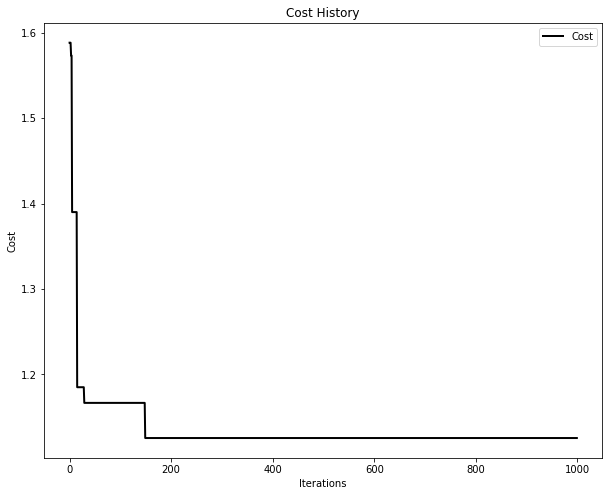

In [17]:
plot_cost_history(tr_optimizer.cost_history)

(1.1254849146960841, 0.625, 0.5078361731254982)

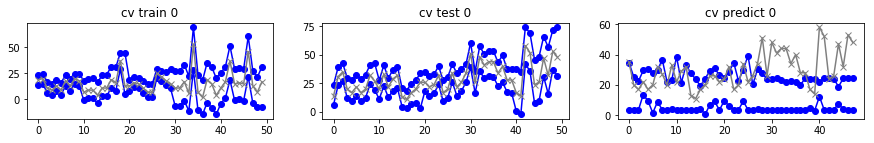

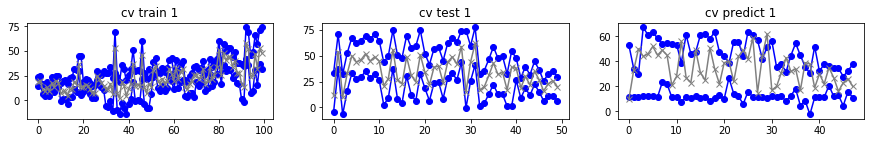

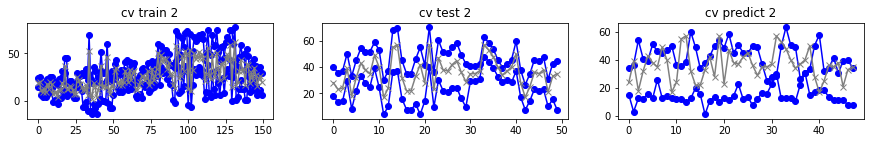

In [18]:
cwcf(*tr_pos, tr_train, tru_train, trl_train, isplt=True)

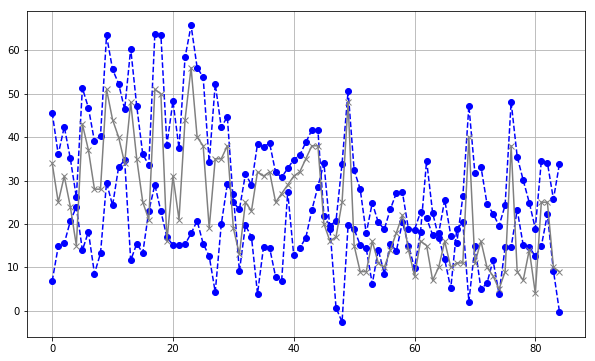

In [66]:
# 滞后期数列 d>1 因为不能用当前点预测当前点
# svm gamma取值范围[0.0001, 1] C取值范围[1,30]，这个范围之后用在
diff = 3
xu_tr, yu_tr = split_to_xy(tru_train, d=range(diff))
xu_te, yu_te = split_to_xy(tru_test, d=range(diff))
svru = svm.SVR(gamma=tr_pos[0], C=tr_pos[1])
svru.fit(xu_tr, yu_tr)
pu = svru.predict(xu_te)

plt.figure(figsize=(10,6))
# plt.subplot(121)
plt.plot(pu, color='blue', marker='o', linestyle='--')
# plt.subplot(122)
# plt.plot(yu_te, color='gray', linestyle='--')

xl_tr, yl_tr = split_to_xy(trl_train, d=range(1,diff))
xl_te, yl_te = split_to_xy(trl_test, d=range(1,diff))
svrl = svm.SVR(gamma=tr_pos[2], C=tr_pos[3])
svrl.fit(xl_tr, yl_tr)
pl = svrl.predict(xl_te)
# plt.subplot(122)
plt.plot(pl, color='blue', marker='o', linestyle='--')
tmp = trend_ts[train_size+diff-1:]
tmp.index = range(len(tmp))
plt.plot(tmp, color='gray', marker='x')
plt.grid()

In [67]:
picp2 = me.picpf(tmp, pu, pl)
pinew2 = me.pinewf(pu, pl)
cwc2 = me.cwcf(picp2, pinew2)
cwc2, picp2, pinew2

(0.28089408024723383, 0.6823529411764706, 0.28089408024723383)

# 检验period

In [21]:
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pe_optimizer = GlobalBestPSO(n_particles=10, dimensions=4, options=options, bounds=pso_bounds())
kwargs = {'cv_t': pe_train, 'cv_u': peu_train, 'cv_l': pel_train}
pe_cost, pe_pos = pe_optimizer.optimize(pso_fitf, iters=1000, **kwargs)

2019-03-03 21:33:39,432 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.726
2019-03-03 21:37:57,908 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.7257480207362565, best pos: [1.02947598e-02 2.67393596e+01 2.76434789e-01 2.50649514e+01]


In [22]:
# array([1.02947598e-02, 2.67393596e+01, 2.76434789e-01, 2.50649514e+01])
pe_pos

array([1.02947598e-02, 2.67393596e+01, 2.76434789e-01, 2.50649514e+01])

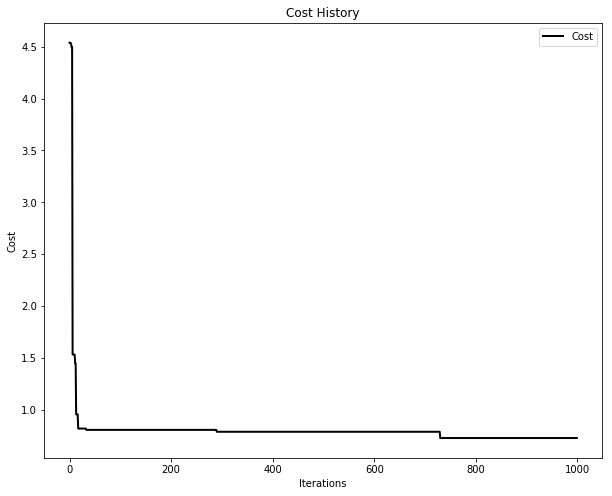

In [23]:
plot_cost_history(pe_optimizer.cost_history)

(0.7257480207362565, 0.625, 0.432122735618992)

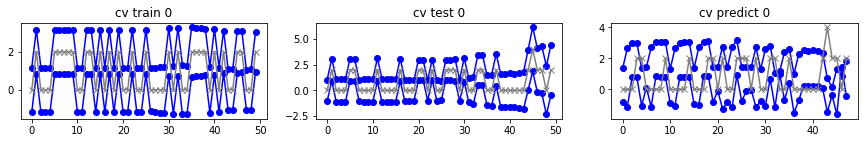

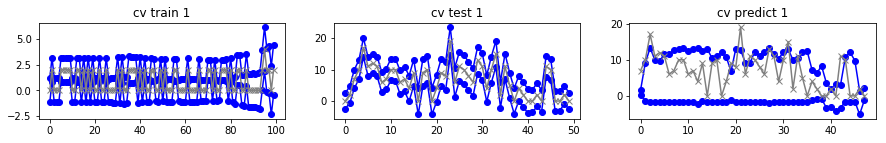

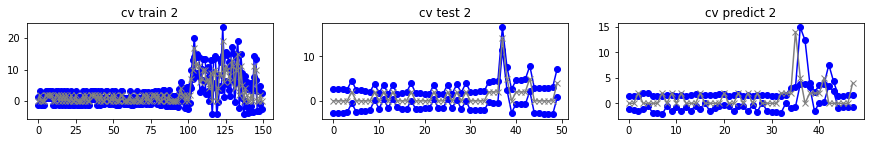

In [27]:
cwcf(*pe_pos, pe_train, peu_train, pel_train,isplt=True)

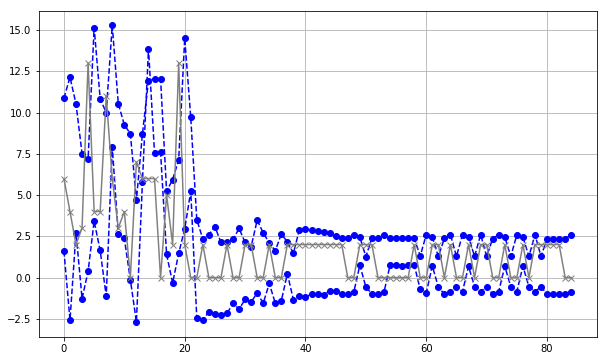

In [68]:
# 滞后期数列 d>1 因为不能用当前点预测当前点
# svm gamma取值范围[0.0001, 1] C取值范围[1,30]，这个范围之后用在
diff=3
xu_tr, yu_tr = split_to_xy(peu_train, d=range(1,diff))
xu_te, yu_te = split_to_xy(peu_test, d=range(1,diff))
svru = svm.SVR(gamma=pe_pos[0], C=pe_pos[1])
svru.fit(xu_tr, yu_tr)
pu = svru.predict(xu_te)

plt.figure(figsize=(10,6))
# plt.subplot(121)
plt.plot(pu, color='blue', marker='o', linestyle='--')
# plt.subplot(122)
# plt.plot(yu_te, color='gray', linestyle='--')

xl_tr, yl_tr = split_to_xy(pel_train, d=range(1,diff))
xl_te, yl_te = split_to_xy(pel_test, d=range(1,diff))
svrl = svm.SVR(gamma=pe_pos[2], C=pe_pos[3])
svrl.fit(xl_tr, yl_tr)
pl = svrl.predict(xl_te)
# plt.subplot(122)
plt.plot(pl, color='blue', marker='o', linestyle='--')
tmp = period_ts[train_size+diff-1:]
tmp.index = range(len(tmp))
plt.plot(tmp, color='gray', marker='x')
plt.grid()

In [69]:
picp3 = me.picpf(tmp, pu, pl)
pinew3 = me.pinewf(pu, pl)
cwc3 = me.cwcf(picp3, pinew3)
cwc3, picp3, pinew3

(0.23320994700248238, 0.7529411764705882, 0.23320994700248238)

In [70]:
np.mean([cwc1,cwc2,cwc3]), np.mean([picp1,picp2,picp3]), np.mean([pinew1,pinew2,pinew3])

(0.3814049031305741, 0.6862745098039215, 0.3814049031305741)

# 效率对比

In [78]:
costs = np.array([sm_optimizer.cost_history, tr_optimizer.cost_history, pe_optimizer.cost_history])

In [76]:
from pyswarms.utils.plotters.formatters import Designer

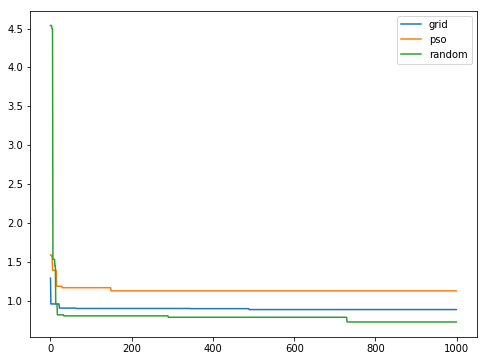

In [105]:
plt.figure(figsize=(8,6))
l1, =plt.plot(costs[0])
l2, =plt.plot(costs[1])
l3, = plt.plot(costs[2])
plt.legend(handles=[l1,l2,l3,], labels = ['grid', 'pso', 'random'], loc = 'best')
plt.show()

In [30]:
# ARIMA做法
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
#Perform Dickey-Fuller test:
def static_test(ts):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
static_test(smu_train)
static_test(smu_test)

Results of Dickey-Fuller Test:
Test Statistic                -1.201290e+01
p-value                        3.150558e-22
#Lags Used                     0.000000e+00
Number of Observations Used    1.990000e+02
Critical Value (1%)           -3.463645e+00
Critical Value (5%)           -2.876176e+00
Critical Value (10%)          -2.574572e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                 -5.577877
p-value                         0.000001
#Lags Used                      9.000000
Number of Observations Used    77.000000
Critical Value (1%)            -3.518281
Critical Value (5%)            -2.899878
Critical Value (10%)           -2.587223
dtype: float64


Test MSE: 185.504


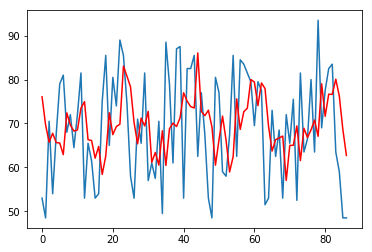

In [45]:
from sklearn.metrics import mean_squared_error
history = [x for x in smu_train]
predictions = list()
for t in range(len(smu_test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = smu_test[t]
	history.append(obs)
error = mean_squared_error(smu_test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(smu_test)
plt.plot(predictions, color='red')
plt.show()